# Fáza 2 - Predspracovanie údajov
Práca bola rozdelená férovo pre oboch zúčastnených
Adam Kubaliak 50%
Norbert Matuška 50% 

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats

import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline


In [3]:
connections = pd.read_csv("dataset-55/connections.csv", sep="\t")
devices = pd.read_csv("dataset-55/devices.csv", sep="\t")
processes = pd.read_csv("dataset-55/processes.csv", sep="\t")
profiles = pd.read_csv("dataset-55/profiles.csv", sep='\t')

## 2.1 Realizácia predspracovania dát

### 2.1 A 
Dáta si rozdeľte na trénovaciu a testovaciu množinu podľa vami preddefinovaného pomeru. Ďalej pracujte len s trénovacím datasetom.

Pomocou premennej imei sme spojili dáta.
Dáta sme si rozdelili na trénovaciu a testovaciu množinu v pomere 80:20, kde 80% dát bude trénovacia množina a 20% testovacia množina. Tento pomer sme zvolili, pretože sa bežne používa a je vhodný pre naše dáta.

In [4]:
data = pd.merge(connections, processes, on=['imei', 'ts', 'mwra'], how='inner')
data.drop_duplicates(inplace=True)

devices = devices.drop_duplicates(subset=['imei'])
profiles = profiles.drop_duplicates(subset=['imei'])
data = pd.merge(data, devices, on='imei', how='inner')
data = pd.merge(data, profiles, on='imei', how='inner')

data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)

data_train.to_csv('data_train.csv', index=False)
data_test.to_csv('data_test.csv', index=False)

### 2.1 B
Transformujte dáta na vhodny formát pre ML t.j. jedno pozorovanie musí byt opísané jednym riadkom a kazdý atribút musí byt v numerickom formáte (encoding). Iteratívne integrujte aj kroky v predspracovani dát z prvej fázy (missing values, outlier detection) ako celok.

In [5]:
data_train.isnull().sum()

ts                               0
imei                             0
mwra                             0
c.katana                         0
c.dogalize                       0
c.android.gm                     0
c.android.chrome                 0
c.android.youtube                0
c.updateassist                   0
c.android.vending                0
c.UCMobile.intl                  0
c.UCMobile.x86                   0
c.raider                         0
p.android.documentsui            0
p.android.packageinstaller       0
p.android.chrome                 0
p.android.gm                     0
p.android.settings               0
p.system                         0
p.android.externalstorage        0
p.browser.provider               0
p.katana                         0
p.android.gms                    0
p.dogalize                       0
p.notifier                       0
p.android.vending                0
p.olauncher                      0
p.inputmethod.latin              0
p.gms.persistent    

Zistili sme, že v dátach chýbajú hodnoty v atribútoch code, residence, birthdate, job a address. Keďže nejde o číselné dátata, sme sa rozhodli dpolniť ich najbežnejšou hodnotou.

In [6]:
missing_values = ['code', 'residence', 'birthdate', 'job', 'address']
for column in missing_values:
    data_train[column] = data_train[column].fillna(data_train[column].mode()[0])
    
data_train.isnull().sum()

ts                            0
imei                          0
mwra                          0
c.katana                      0
c.dogalize                    0
c.android.gm                  0
c.android.chrome              0
c.android.youtube             0
c.updateassist                0
c.android.vending             0
c.UCMobile.intl               0
c.UCMobile.x86                0
c.raider                      0
p.android.documentsui         0
p.android.packageinstaller    0
p.android.chrome              0
p.android.gm                  0
p.android.settings            0
p.system                      0
p.android.externalstorage     0
p.browser.provider            0
p.katana                      0
p.android.gms                 0
p.dogalize                    0
p.notifier                    0
p.android.vending             0
p.olauncher                   0
p.inputmethod.latin           0
p.gms.persistent              0
p.google                      0
p.android.defcontainer        0
p.simula

Ďalej sme transformovali kategorické atribúty na číselné pomocou OrdinalEncoder. Použili sme ho kvôli tomu, že OrdinalEncoder je vhodný pre kategorické atribúty s vyšším počtom hodnôt.

In [7]:
for column in data_train.columns:
    if data_train[column].dtype == 'object':
        print(f'{column} = {data_train[column].nunique()}')

ts = 11908
store_name = 397
code = 91
location = 122
residence = 192
birthdate = 272
job = 136
mail = 496
registration = 485
name = 496
username = 496
ssn = 497
company = 483
address = 421


In [8]:
tmp = []
for column in data_train.columns:
    if data_train[column].dtype == 'object' and column != 'ts':
        tmp.append(column)

ce_ordinal = ce.OrdinalEncoder(cols=tmp)
data_train = ce_ordinal.fit_transform(data_train)

Ďalej sme transformovali atribút ts na numerický formát. Z atribútu sme odstránili znaky, ktoré nám bránili v transformácii na numerický formát, preože táto zmena nám umožní ďalej pracovať s týmto atribútom.

In [9]:
data_train['ts_numeric'] = data_train['ts'].str.replace('[-: ]', '', regex=True).astype(int)
data_train.drop(columns=['ts'], inplace=True)

In [10]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11908 entries, 4417 to 7270
Data columns (total 49 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   imei                        11908 non-null  int64  
 1   mwra                        11908 non-null  float64
 2   c.katana                    11908 non-null  float64
 3   c.dogalize                  11908 non-null  float64
 4   c.android.gm                11908 non-null  float64
 5   c.android.chrome            11908 non-null  float64
 6   c.android.youtube           11908 non-null  float64
 7   c.updateassist              11908 non-null  float64
 8   c.android.vending           11908 non-null  float64
 9   c.UCMobile.intl             11908 non-null  float64
 10  c.UCMobile.x86              11908 non-null  float64
 11  c.raider                    11908 non-null  float64
 12  p.android.documentsui       11908 non-null  float64
 13  p.android.packageinstaller  11908 

Odstránili sme outliery pomocou IQR metódy. Outliery sme sa rozhodli odstrániť, pretože by mohli ovplyvniť výsledky modelu. Po odstránení outlierov nám ostalo dostatočné množstvo dát na trénovanie modelu.

In [11]:
for column in data_train.columns:
    Q1 = data_train[column].quantile(0.25)
    Q3 = data_train[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    data_train = data_train[(data_train[column] >= lower_bound) & (data_train[column] <= upper_bound)]

data_train.shape

(6644, 49)

### 2.1 C
Transformujte atribúty dát pre strojové ucenie podia dostupných technik minimálne: scaling (2 techniky), transformers (2 techniky) a d'alsie. Cielom je aby ste testovali efekty a vhodne kombinovali v dátovom pipeline (od easti 2.3 a v 3. fáze).

Atribúty sme transformovali pomocou MinMaxScaler a RobustScaler. Ďalej sme transformovali dáta pomocou PowerTransformer a QuantileTransformer.
Po transformácii sme vizualizovali dáta pomocou histogramov, aby sme porovnali výsledky transformácie.
Pre machine learning pipeline sme zvolili kombináciu RobustScaler a PowerTransformer, pretože tieto techniky nám dali najlepšie výsledky.

In [12]:
data_features = data_train.drop(columns=['mwra'])
mwra_column = data_train['mwra']

scalers = {
    'minmax': MinMaxScaler(),
    'robust': RobustScaler()
}

transformers = {
    'yeo_johnson': PowerTransformer(method='yeo-johnson'),
    'quantile': QuantileTransformer(n_quantiles=100, output_distribution='normal')
}
results = {}

for scaler_name, scaler in scalers.items():
    scaled_data = scaler.fit_transform(data_features)
    
    for transformer_name, transformer in transformers.items():
        transformed_data = transformer.fit_transform(scaled_data)
        transformed_df = pd.DataFrame(transformed_data, columns=data_features.columns)
        transformed_df['mwra'] = mwra_column.values
        results[f"{scaler_name}_{transformer_name}"] = transformed_df

In [13]:
data_train = results['robust_yeo_johnson']

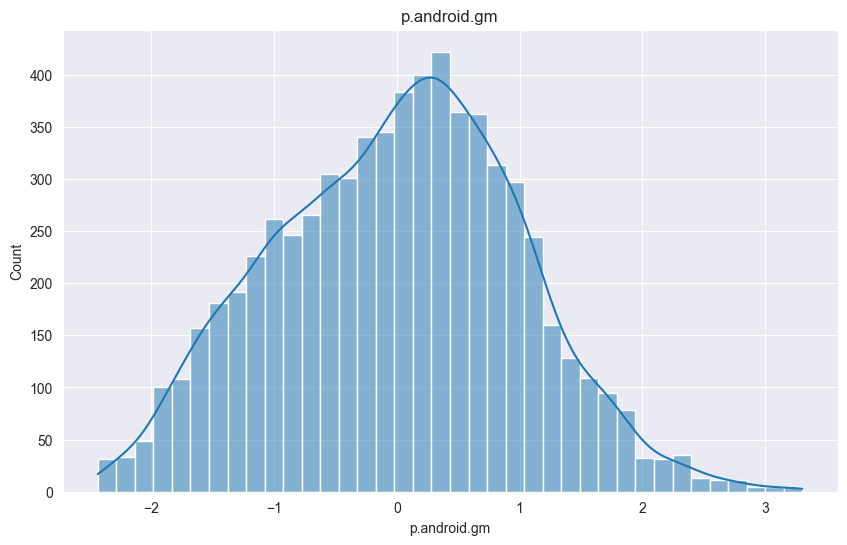

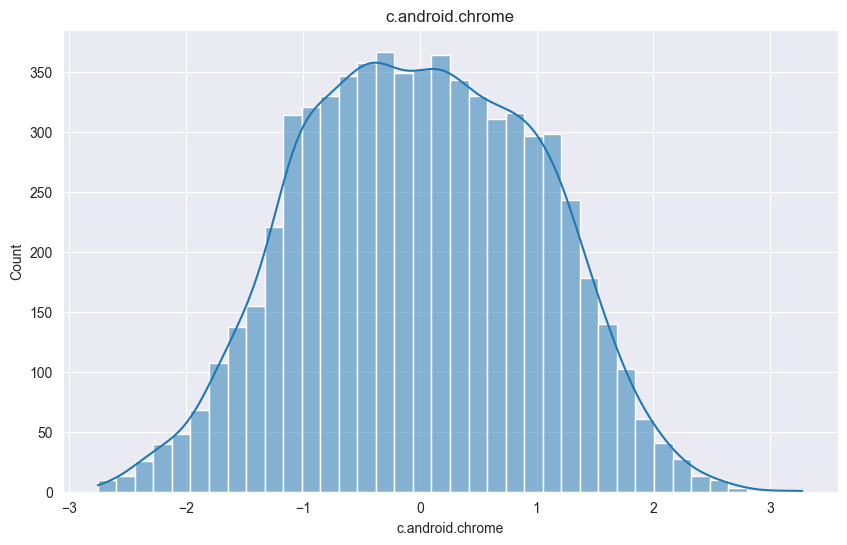

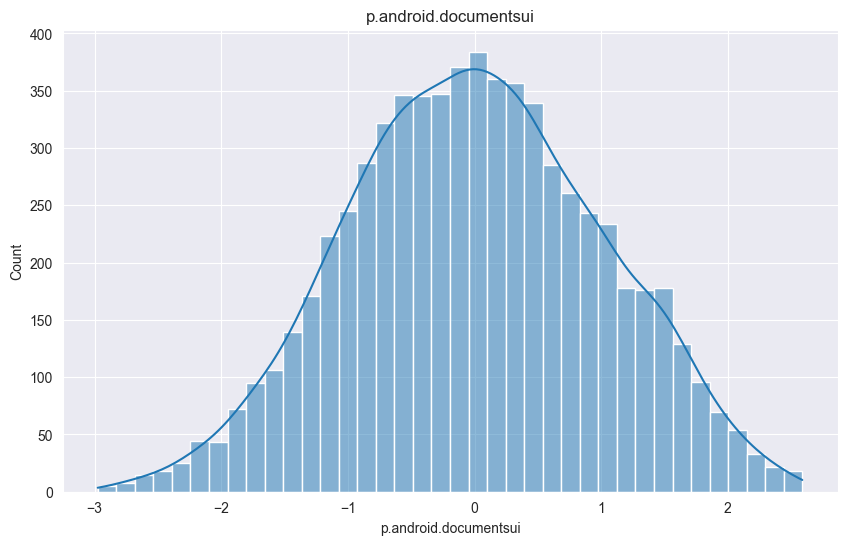

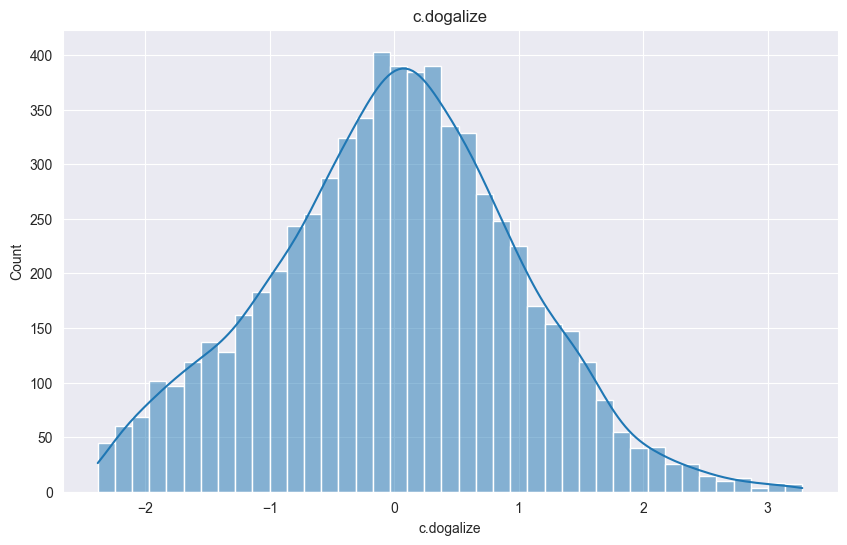

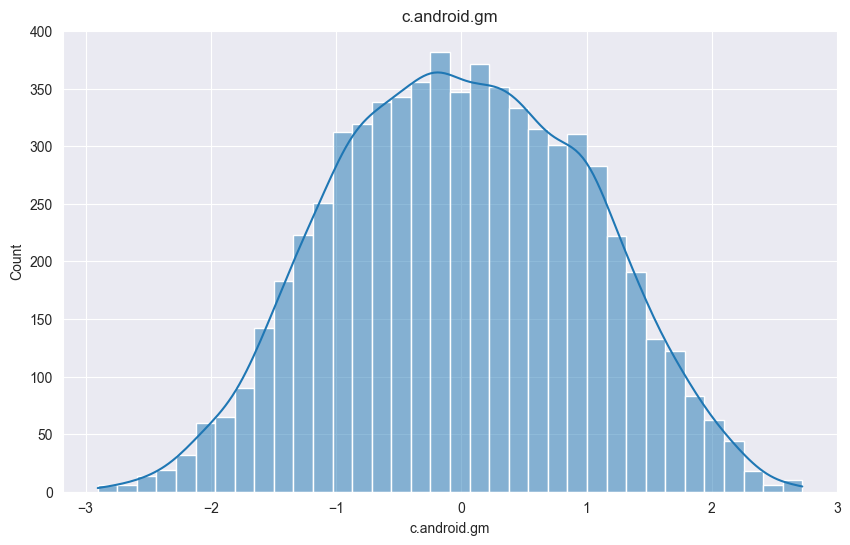

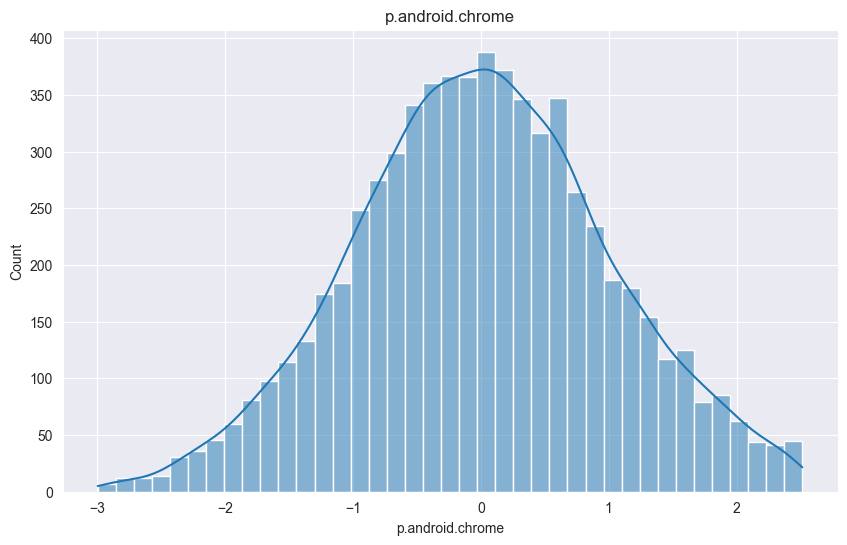

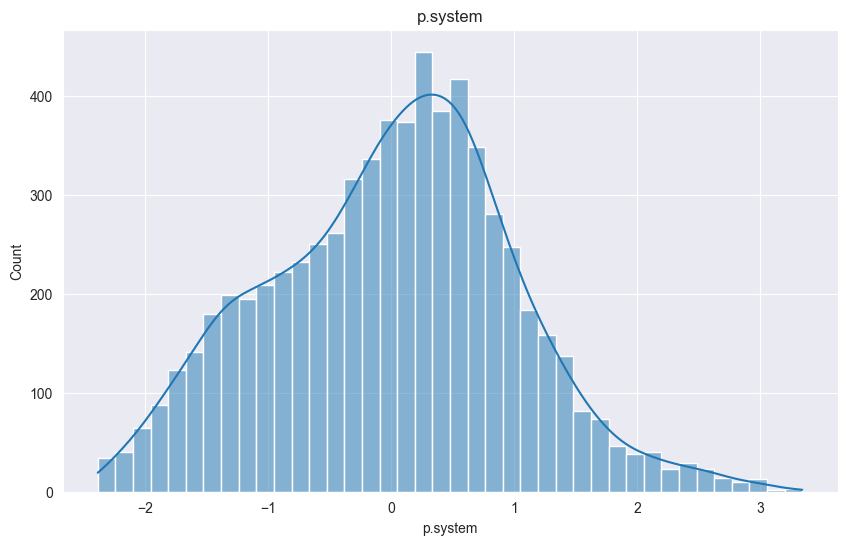

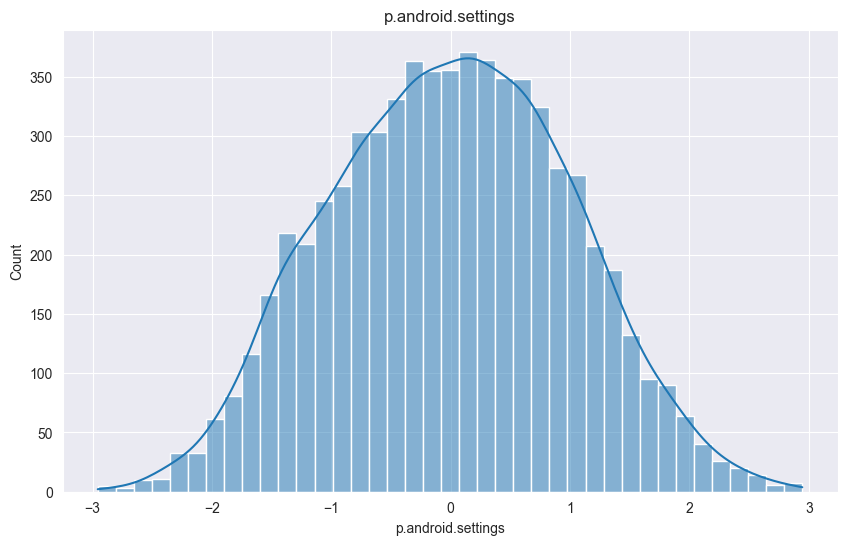

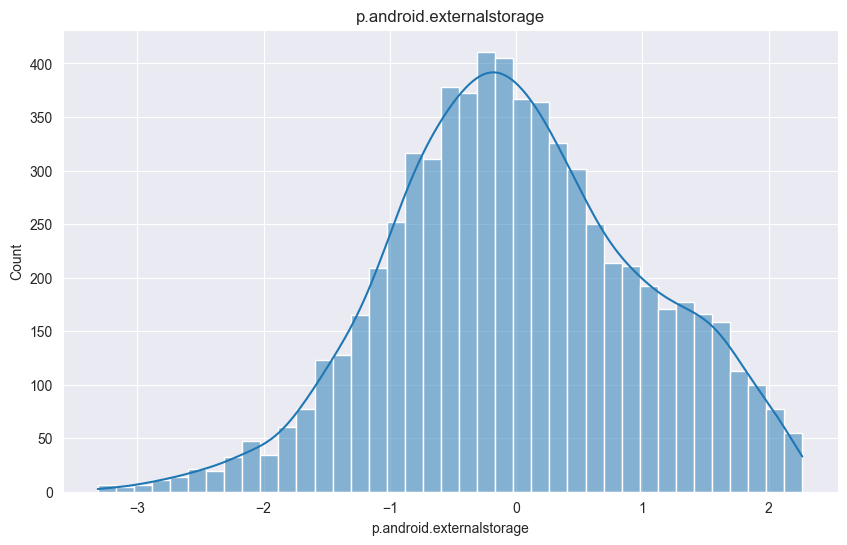

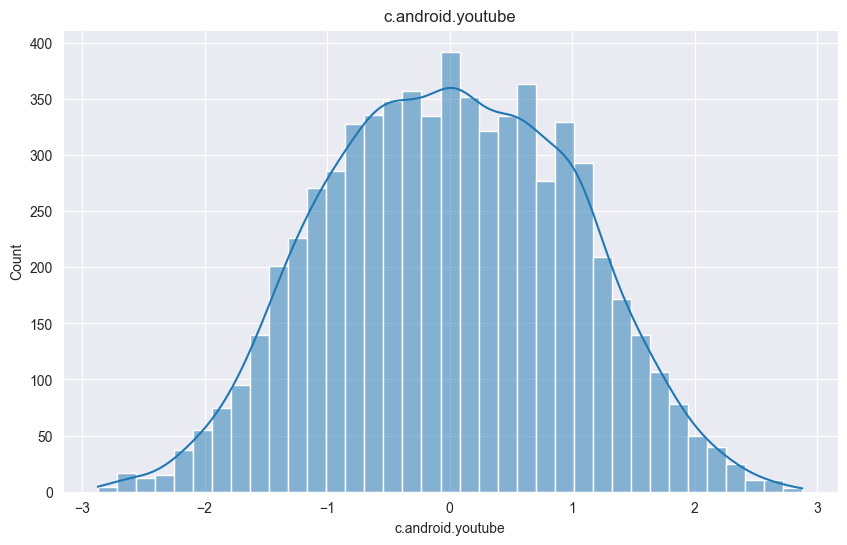

In [14]:
for column in ['p.android.gm', 'c.android.chrome', 'p.android.documentsui',
       'c.dogalize', 'c.android.gm', 'p.android.chrome', 'p.system',
       'p.android.settings', 'p.android.externalstorage',
       'c.android.youtube']:
    plt.figure(figsize=(10, 6))
    sns.histplot(data_train[column], kde=True)
    plt.title(column)
    plt.show()

### 2.1 D
Zdôvodnite Vase volby/rozhodnutie pre realizáciu (t.j. zdokumentovanie)

Našim cieľom bolo transformovať dáta do vhodného formátu pre strojové učenie. Aby sme dosiahli tento cieľ, museli sme vykonať niekoľko krokov:
- Ako prvé sme odhalili chýbajúce hodnoty v atribútoch code, residence, birthdate, job a address. Keďže nejde o číselné dátata, sme sa rozhodli doplniť ich najbežnejšou hodnotou.
- Ďalej sme transformovali kategorické atribúty na číselné pomocou ordinal encoderu. Použili sme ho kvôli tomu, že je vhodný pre atribúty s vyšším počtom hodnôt.
- Potom sme transformovali atribút ts na numerický formát. Z atribútu sme odstránili znaky a táto zmena nám umožní ďalej pracovať s týmto atribútom.
- Odstránili sme outliery pomocou IQR metódy. Outliery sme sa rozhodli odstrániť, pretože by mohli ovplyvniť výsledky modelu. Po odstránení outlierov nám ostalo dostatočné množstvo dát na trénovanie modelu.
- Atribúty sme transformovali pomocou MinMaxScaler a RobustScaler. Ďalej sme transformovali dáta pomocou PowerTransformer a QuantileTransformer.
- Po transformácii sme vizualizovali dáta pomocou histogramov, aby sme porovnali výsledky transformácie.

Pre machine learning sme sa rozhodli použiť kombináciu RobustScaler a PowerTransformer, pretože tieto techniky nám dali najlepšie výsledky.

### 2.2 A
Zistite, ktore atributy (features) vo vasich datach pre ML su informativne k predikovane premenne (minimalne 3 techniky s porovnanim meazi sebou).

## 2.2 Vyber atribútov pre strojové ucenie

In [15]:
X_train = data_train.drop(columns=['mwra'])
y_train = data_train['mwra'].astype(int)

# 1. Correlation Analysis
correlations = X_train.corrwith(y_train).abs()

# 2. ANOVA F-test
anova_selector = SelectKBest(f_classif, k='all')
anova_selector.fit(X_train, y_train)
anova_scores = anova_selector.scores_

# 3. Random Forest Feature Importance
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_importances = rf_model.feature_importances_

# Combine results into a DataFrame for comparison
feature_names = X_train.columns
selection_results = pd.DataFrame({
    'Feature': feature_names,
    'Correlation': correlations.values,
    'ANOVA F-score': anova_scores,
    'RFI': rf_importances
})

print(selection_results)

                       Feature  Correlation  ANOVA F-score       RFI
0                         imei     0.010425       0.721956  0.002376
1                     c.katana     0.007229       0.347142  0.025806
2                   c.dogalize     0.326154     790.659715  0.063781
3                 c.android.gm     0.289642     608.242099  0.043218
4             c.android.chrome     0.540403    2739.822110  0.133115
5            c.android.youtube     0.020504       2.793606  0.029736
6               c.updateassist     0.013871       1.278173  0.010595
7            c.android.vending     0.018472       2.267013  0.009587
8              c.UCMobile.intl     0.014824       1.459971  0.009004
9               c.UCMobile.x86     0.018451       2.261913  0.008894
10                    c.raider     0.004152       0.114521  0.008464
11       p.android.documentsui     0.527141    2555.883253  0.117783
12  p.android.packageinstaller     0.014942       1.483222  0.010332
13            p.android.chrome    

### 2.2 B
Zoradte zistené atribúty v poradí podia dôlezitosti.

In [16]:
selection_results_sorted = selection_results.sort_values(
    by=['RFI', 'ANOVA F-score', 'Correlation'], 
    ascending=False
)

print(selection_results_sorted[['Feature', 'RFI', 'ANOVA F-score', 'Correlation']])
important_features = selection_results_sorted['Feature'].values[:10]

                       Feature       RFI  ANOVA F-score  Correlation
14                p.android.gm  0.142847    3215.767775     0.571154
4             c.android.chrome  0.133115    2739.822110     0.540403
11       p.android.documentsui  0.117783    2555.883253     0.527141
2                   c.dogalize  0.063781     790.659715     0.326154
3                 c.android.gm  0.043218     608.242099     0.289642
13            p.android.chrome  0.042731     306.626782     0.210066
16                    p.system  0.041817     553.553616     0.277362
15          p.android.settings  0.040070     578.548861     0.283064
17   p.android.externalstorage  0.037409     637.458926     0.295922
5            c.android.youtube  0.029736       2.793606     0.020504
1                     c.katana  0.025806       0.347142     0.007229
28      p.android.defcontainer  0.010849       0.121336     0.004274
6               c.updateassist  0.010595       1.278173     0.013871
12  p.android.packageinstaller  0.

In [17]:
for column in data_train.columns:
    if column not in important_features and column != 'mwra':
        data_train.drop(columns=[column], inplace=True)

data_train.to_csv('data_train_best_features.csv', index=False)

## 2.3 Replikovatelnost predspracovania

### 2.3 A
Upravte váš kód realizujúci predspracovanie trénovacej množiny tak, aby ho bolo možné bez dalsich úprav znovu použiť na predspracovanie testovacej mnoziny v kontexte strojového učenia.

In [23]:
data_test = pd.read_csv('data_test.csv')
important_features_data = None

for column in data_test.columns:
    if column in important_features or column == 'mwra':
        important_features_data = pd.concat([important_features_data, data_test[[column]]], axis=1)

['p.android.gm' 'c.android.chrome' 'p.android.documentsui' 'c.dogalize'
 'c.android.gm' 'p.android.chrome' 'p.system' 'p.android.settings'
 'p.android.externalstorage' 'c.android.youtube']


In [19]:
for column in important_features_data.columns:
    Q1 = important_features_data[column].quantile(0.25)
    Q3 = important_features_data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    important_features_data = important_features_data[(important_features_data[column] >= lower_bound) & (important_features_data[column] <= upper_bound)]

Z testovacích dát sme odstránili atribúty, ktoré nie sú v trénovacej množine. Následne sme odstránili outliery pomocou IQR metódy.

### 2.3 B
Vyuzite moznosti sklearn.pipeline

In [20]:
pipeline = Pipeline([
    ('scaling', RobustScaler()),
    ('transformation', PowerTransformer(method='yeo-johnson'))
])

In [21]:
features_to_transform = important_features_data.drop(columns=['mwra'])
transformed_features = pipeline.fit_transform(features_to_transform)

data_test_best_features = pd.DataFrame(transformed_features, columns=features_to_transform.columns)
data_test_best_features['mwra'] = important_features_data['mwra'].values

data_test_best_features.to_csv('data_test_best_features.csv', index=False)

Pomocou pipeline sme transformovali dáta z testovacej množiny. Použili sme rovnaké techniky ako pri trénovacej množine.